In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

IPythonConsole.ipython_useSVG=True
from IPython.display import Image

import dgl, networkx as nx
import torch
import matplotlib.pyplot as plt

import torch.autograd.profiler as profiler

import core.preprocess as p
from core.models.autoencoder import Autoencoder
import core.train as train
from core.postprocess import hier_graph_to_mol

def label_idx(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

def clear_labels(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(0)
    return mol

def show_graph(graph, method):
    nxg = dgl.to_homogeneous(graph).to_networkx()
    
    if method == "gv":
        ngd = nx.drawing.nx_agraph.to_agraph(nxg)
        ngd.layout('dot')
        nx.drawing.nx_agraph.write_dot(nxg, "test.dot")
        !neato -T png test.dot > test.png
        return Image("test.png")
    elif method == "nx":
        return nx.draw(nxg, with_labels = True)
    else:
        return "Unknown method"

## Setup dataset, train, and test

##### Dataset
Make sure there's a path ../data/debugset/raw/mols_few.txt, where mols_few.txt has a SMILES string on every line, and ../data/debugset/processed/. 

In [3]:
import core.dataset as dataset

#ds = dataset.MolDataset("zinc", "../data", "raw", "processed", "train.txt", 50)
ds = dataset.MolDataset("debugset", "data", "raw", "processed", "mols_smol.txt", 0)
ds.process()

val_size = (len(ds) // 10) + 1
train_size = len(ds) - val_size
assert train_size + val_size == len(ds)
train_data, val_data = torch.utils.data.random_split(
    ds, [train_size, val_size]
)

Done loading data from cached files.
Building vocabs...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 61.22it/s]


Decomposing...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 205.19it/s]


Getting final graphs...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 506.03it/s]


In [6]:
len(ds)

11

##### Display example data

Original:  CCCC1CCCC1CC
Fragmented:  CC1CCCC1.CCC.CCC


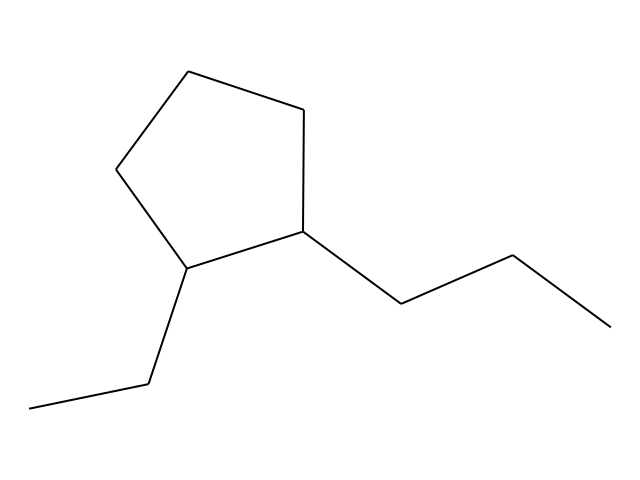

In [7]:
idx = 0
print("Original: ", ds.mol_SMILES["orig"][idx])
print("Fragmented: ", ds.mol_SMILES["frag"][idx])
original = Chem.MolFromSmiles(ds.mol_SMILES["orig"][idx])
fragmented = Chem.MolFromSmarts(ds.mol_SMILES["frag"][idx])
rdkit.Chem.Draw.MolsToGridImage([original], molsPerRow=1, subImgSize=(640, 480))

In [ ]:
label_idx(fragmented)
fragmented
#rdkit.Chem.Draw.ShowMol(label_idx(fragmented), (640, 480))

In [ ]:
motif_vocab_idx = 0
Chem.MolFromSmiles(ds.vocabs["motif"]["node"][motif_vocab_idx])

In [ ]:
atom_graph = ds.mol_hgraphs[0].node_type_subgraph(["atom"])
atom_edges = atom_graph.edges(etype = ("atom", "bond", "atom"))
show_graph(atom_graph, "gv")

In [ ]:
idx = idx
motif_graph = ds.mol_hgraphs[idx].node_type_subgraph(["motif"])
motif_attch_graph = ds.mol_hgraphs[idx].edge_type_subgraph([("motif", "attaches to", "motif")])
motif_ancestry_graph = ds.mol_hgraphs[idx].edge_type_subgraph([("motif", "ancestry", "motif")])
motif_edges = motif_graph.edges(etype = ("motif", "attaches to", "motif"))
edge_attchs = ds.mol_hgraphs[idx].edges[("motif", "attaches to", "motif")].data["attachment_motif_id_pair"]
motif_ndata = motif_graph.nodes["motif"].data
print("Edges between motifs and the IDs of the atoms at which they attach:")
print(list(zip(motif_edges[0].tolist(), motif_edges[1].tolist(), edge_attchs.tolist())))
print("(id, vocab idx, smiles)")
print([(i, idx.item(), ds.vocabs["motif"]["node"][idx]) for i, idx in enumerate(motif_ndata["vocab_idx"])])
show_graph(motif_attch_graph, "nx")

In [ ]:
hier_graph_to_mol(ds.mol_hgraphs[idx], ds.vocabs)

In [ ]:
show_graph(ds.motif_graphs[0], "nx")

##### Initialize model, train it, and test it.

In [19]:
from core.models.message_passing import GCN, RNN_MPN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(ds.vocabs, ds.motif_graphs, node_rep_size = 200, latent_size = 200,
                    rep_activation = torch.nn.ReLU, attach_prediction_method = "dot", neighbor_hops = 2,
                    variational = True, device = device, mpn_model = GCN)

In [ ]:
collate = lambda batch: dataset.collate_(batch, device)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size = 4, shuffle = False, collate_fn = collate)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size = 4, shuffle = False, collate_fn = collate)

optimizer = torch.optim.Adam(model.parameters(), lr=.001)
train.train(model = model, optimizer = optimizer, reconst_weight = 1, KL_weight = .2,
            train_data_loader = train_dataloader, val_data_loader = val_dataloader,
            val_interval = None, val_log_interval = None, epochs = 500, log_interval = 1)

##### Test it

In [22]:
import gc; gc.collect()

idxs = range(len(ds.mol_hgraphs))
hgraphs_in = [ds.mol_hgraphs[idx] for idx in idxs] #[ds.mol_hgraphs[0]]
print(len(ds.mol_hgraphs))
model.eval()

with profiler.profile(record_shapes=True, with_stack=True) as prof:
    with torch.no_grad():
        hgraphs_out = model(hgraphs_in, max_motifs = 200)

11


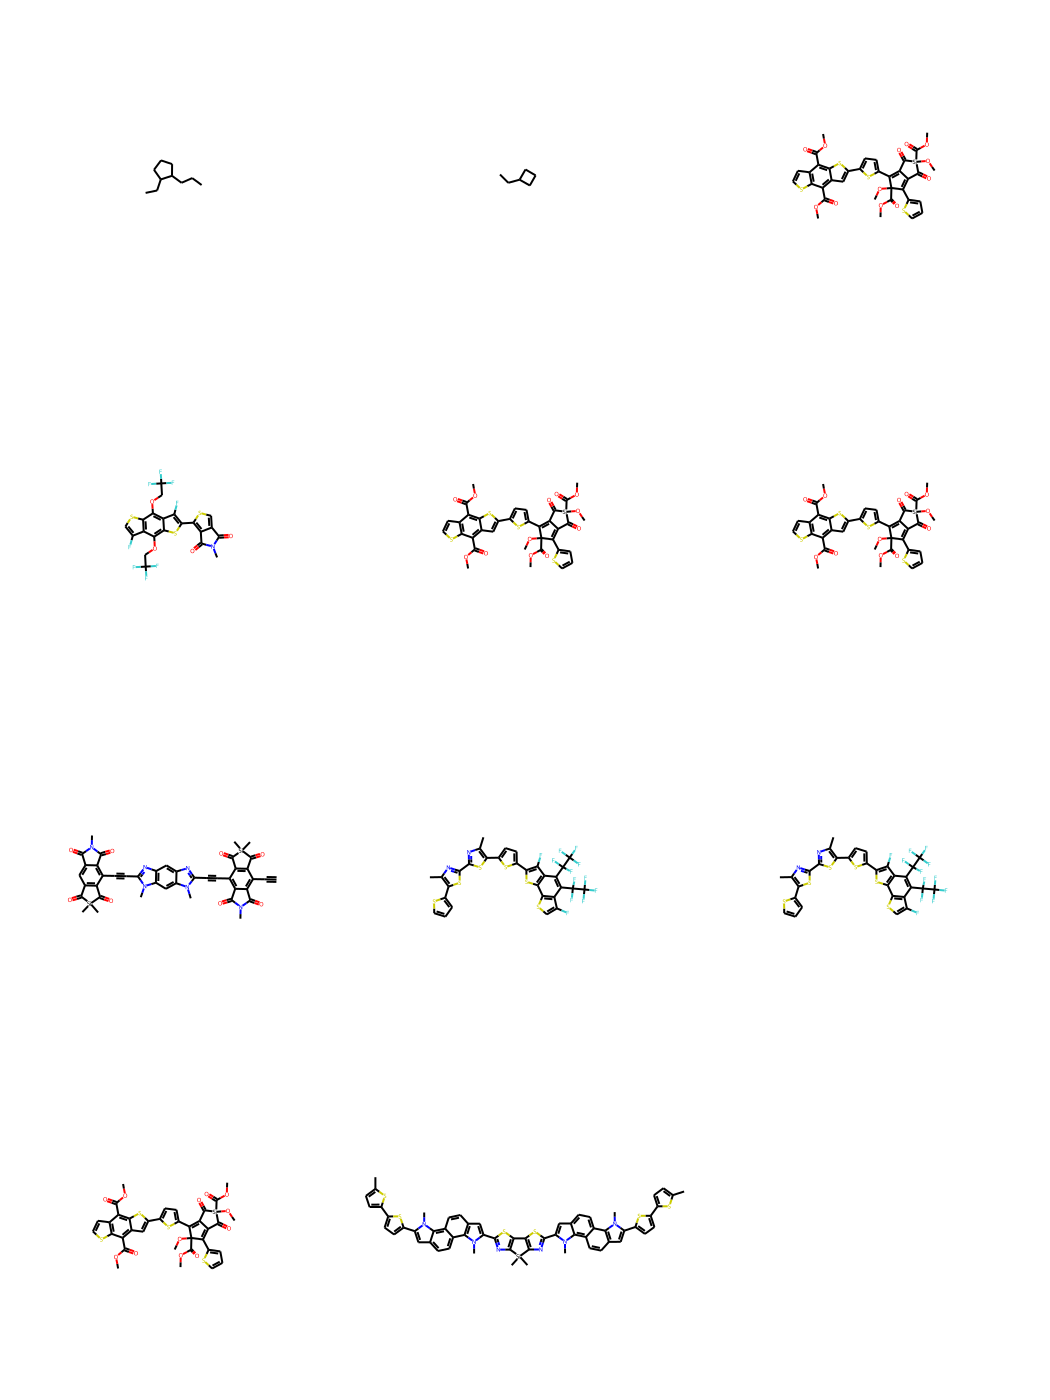

In [23]:
out_mols = []
for hgraph in hgraphs_out:
    #Chem.Kekulize(out_mol)
    mol = hier_graph_to_mol(hgraph, ds.vocabs)
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    out_mols.append(mol)
    print(mol)
#Display all
Draw.MolsToGridImage(out_mols, molsPerRow = 3, subImgSize = (350, 350))

##### Get target mols

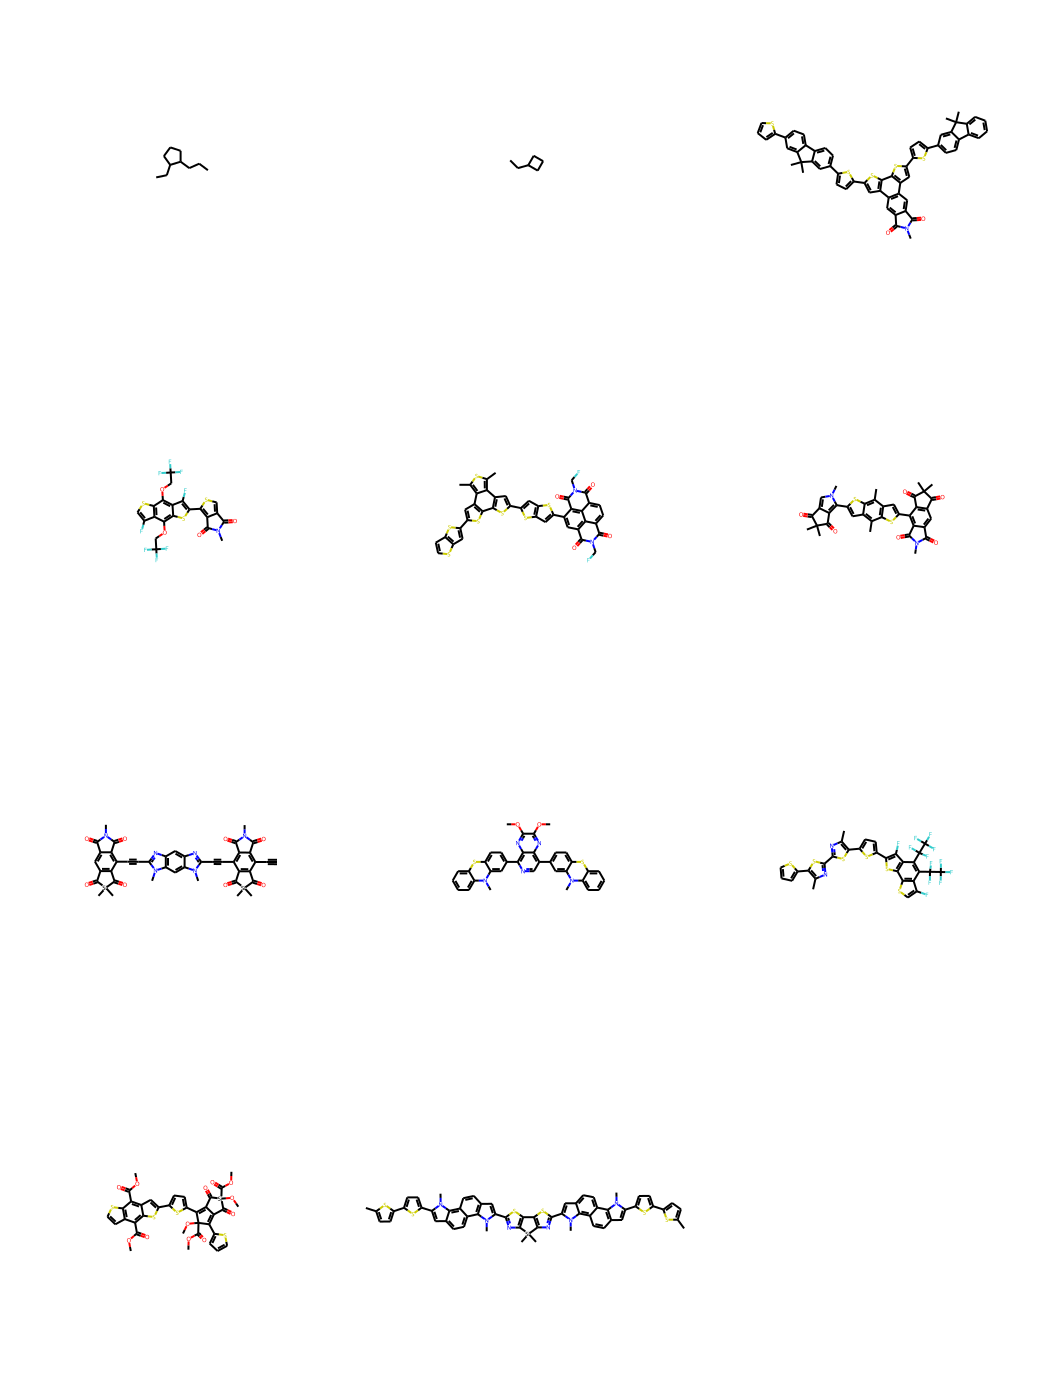

In [13]:
def get_mols(idxs):
    return [Chem.MolFromSmiles(ds.mol_SMILES["orig"][i]) for i in idxs]

idxs = range(len(ds.mol_SMILES["orig"]))
mols = get_mols(idxs)

Draw.MolsToGridImage(mols, molsPerRow = 3, subImgSize = (350, 350))

##### Generate teacher-forced out_mols

In [ ]:
import gc; gc.collect()
input_graphs = [ds.mol_hgraphs[idx] for idx in idxs]
target_graphs = [ds.mol_hgraphs[idx] for idx in idxs]

model.eval()
with torch.no_grad():
    output_graphs, reconst_loss, kl_loss = model(input_graphs, target_graphs, max_motifs = 100)

out_mols = []
for output_graph in output_graphs:
    out_mols.append(hier_graph_to_mol(output_graph, ds.vocabs))

##### Compare out_mols to target mols

In [ ]:
from core.postprocess import get_similarity
#print(out_mols)
for i, (mol, out_mol) in enumerate(zip(mols, out_mols)):
    if out_mol is not None:
        sim = get_similarity(mol, out_mol)
    else:
        sim = "None"
        
    print(i, sim)

In [ ]:
idx=6
Draw.MolsToGridImage([mols[idx], out_mols[idx]], molsPerRow = 3, subImgSize = (350, 350))